In [1]:
# imports
import pickle
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import StratifiedKFold, train_test_split
from sympy.stats.rv import probability
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler # To preprocess data for SVM - greatly improves performance
from sklearn.svm import SVC
from pytorch_tabr import TabRClassifier as TabRClassifier_
import lime
import lime.lime_tabular
import shap
from sklearn.inspection import permutation_importance
from itertools import product
from typing import Tuple, Union, Optional, Callable
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings

In [2]:
def SVMClassifier(**hyperparams):
    return make_pipeline(StandardScaler(), SVC(**hyperparams))

In [3]:
class TabRClassifier(TabRClassifier_):
    def __init__(self, **kwargs):
        # selection_function_name="sparsemax",
        # context_dropout=0.5,
        # context_sample_size=2000,
        # num_embeddings={"type": "PLREmbeddings", "n_frequencies": 32, "frequency_scale": 32, "d_embedding": 32, "lite": False},
        super().__init__(**kwargs)
        self.type_embeddings="one-hot"
        self.device_name="cpu"
        self.optimizer_params={"lr": 2e-4}
        
    def fit(
        self,
        X_train: pd.DataFrame,
        y_train: pd.DataFrame,
        **kwargs
    ) -> None:
        super().fit(X_train=X_train.values, y_train=y_train.values,
                    max_epochs=1, batch_size=25, **kwargs)
        
    def predict(self, X: pd.DataFrame):
        return super().predict(X=X.values)
    
    def predict_proba(self, X: pd.DataFrame):
        if isinstance(X, pd.DataFrame):
            return super().predict_proba(X=X.values)
        else:
            return super().predict_proba(X=X)
        

In [4]:
# constants
SEED = 42
NUM_SPLITS = 3
INITIAL_CUTOFF = 0.5
TOP = 0.34
TARGET = "decision"
MODELS = [SVMClassifier, TabRClassifier, XGBClassifier]

XGBCLASSIFIER_HYPERPARAMETERS = {
    "max_depth": [3, 6, 9],
    "min_child_weight": [1, 4, 8],
}

SVMCLASSIFIER_HYPERPARAMETERS = {
    "kernel": ['poly', 'rbf', 'sigmoid'],
    'degree': [1, 2, 3],
    'C': [0.5, 1, 2]
    # "device": ["cuda"],
}

TABRCLASSIFIER_HYPERPARAMETERS = {
   "d_main": [12, 36],
    "d_multiplier": [1.5, 2],
    "context_dropout":  [0, 0.5],
    "dropout0":  [0, 0.5],
    "dropout1":  ["dropout0"],
    "seed": [SEED]
}

HYPERPARAMETERS = {
    XGBClassifier.__name__ : XGBCLASSIFIER_HYPERPARAMETERS,
    SVMClassifier.__name__ : SVMCLASSIFIER_HYPERPARAMETERS,
    TabRClassifier.__name__ : TABRCLASSIFIER_HYPERPARAMETERS
}

In [5]:
def one_hot_encode(df, features):
    for feature in features:
        dummies = pd.get_dummies(df.loc[:, feature], prefix=feature)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(feature, axis=1)
    return df

In [6]:
# load dataset
dataset = pd.read_csv("SpeedDating.csv", index_col=0)

# remove redundant columns
subset = ['gender', 'age', 'age_o', 'race', 'race_o', 'importance_same_race', 'importance_same_religion',
          'pref_o_attractive', 'pref_o_sincere', 'pref_o_intelligence',
          'pref_o_funny', 'pref_o_ambitious', 'pref_o_shared_interests', 'attractive_o', 'sinsere_o', 'intelligence_o', 'funny_o',
          'ambitous_o', 'shared_interests_o', 'attractive_important', 'sincere_important', 'intellicence_important', 'funny_important', 'ambtition_important',
          'shared_interests_important', 'attractive', 'sincere', 'intelligence', 'funny', 'ambition', 'attractive_partner', 'sincere_partner',
          'intelligence_partner', 'funny_partner', 'ambition_partner', 'shared_interests_partner',
          'sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies', 'concerts',
          'music', 'shopping', 'yoga',
          'interests_correlate', 'expected_happy_with_sd_people', 'expected_num_matches', 'expected_num_interested_in_me',
          'like', 'guess_prob_liked', 'decision']

dataset = dataset.loc[:, subset]
dataset.loc[:, 'gender'] = (dataset.loc[:, 'gender'] == 'female') # one hot encode gender
dataset = one_hot_encode(dataset, ['race', 'race_o'])
dataset = dataset.apply(pd.to_numeric, errors='coerce', axis=1)
dataset = dataset.fillna(dataset.mean())
print(dataset.head())
X, y = dataset.loc[:, dataset.columns != TARGET], dataset.loc[:, TARGET]
BASELINE = np.sum(y == 1) / np.sum(y == 0)


C:\Users\mracz\AppData\Local\Temp\ipykernel_16112\3974884003.py:2: DtypeWarning: Columns (4,11,12,16,17,18,19,20,40,41,42,43,44,45,52,53,54,55,56,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,108,110) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv("SpeedDating.csv", index_col=0)


    gender   age  age_o  importance_same_race  importance_same_religion  \
id                                                                        
1      1.0  21.0   27.0                   2.0                       4.0   
2      1.0  21.0   22.0                   2.0                       4.0   
3      1.0  21.0   22.0                   2.0                       4.0   
4      1.0  21.0   23.0                   2.0                       4.0   
5      1.0  21.0   24.0                   2.0                       4.0   

    pref_o_attractive  pref_o_sincere  pref_o_intelligence  pref_o_funny  \
id                                                                         
1                35.0            20.0                 20.0          20.0   
2                60.0             0.0                  0.0          40.0   
3                19.0            18.0                 19.0          18.0   
4                30.0             5.0                 15.0          40.0   
5                3

In [7]:
def train_test_models(models, hyperparameters, X, y):
    accuracies = {}
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=SEED)
    for model_class in models:
        model_hyperparameters = hyperparameters[model_class.__name__]
        accuracies[model_class.__name__] = []
        for hyperparams in tqdm(product(*model_hyperparameters.values())):
            kwargs = dict(zip(model_hyperparameters.keys(), hyperparams))
            if model_class.__name__ == 'SVMClassifier':
                if kwargs['kernel'] != 'poly' and kwargs['degree'] != 3:
                    continue
            model = model_class(**kwargs)
            model.fit(X_train, y_train)
            acc = np.mean(model.predict(X_test) == np.array(y_test))
            accuracies[model_class.__name__].append((acc, kwargs))
    return accuracies

In [8]:
def cross_validate_models(models, kwargs_lists, X, y):
    accuracies = {}
    kf = StratifiedKFold(n_splits=NUM_SPLITS, shuffle=True, random_state=SEED)
    for model_class in models:
        accuracies[model_class.__name__] = []
        for kwargs in tqdm(kwargs_lists[model_class.__name__]):
            s=0
            model = model_class(**kwargs)
            for train_idx, test_idx in kf.split(X, y):
                X_train, y_train = X.iloc[train_idx, :], y.iloc[train_idx]
                X_test, y_test = X.iloc[test_idx, :], y.iloc[test_idx]
                model.fit(X_train, y_train)
                s += np.mean(model.predict(X_test) == np.array(y_test))
            accuracies[model_class.__name__].append((s/NUM_SPLITS, kwargs))
    return accuracies

In [9]:
def get_top_kwargs(models, accuracies, cutoff):
    top_kwargs = {}
    for model_class in models:
        _, top_models_ = zip(*(sorted(accuracies[model_class.__name__], key=lambda x: x[0])[-int(cutoff*len(accuracies[model_class.__name__])):]))
        top_kwargs[model_class.__name__] = list(top_models_)
    return top_kwargs

In [10]:
def get_rashomon_sets(models, hyperparameters, X, y, initial_cutoff=0.5, top=0.34):
    assert top <= initial_cutoff
    initial_accuracies = train_test_models(models, hyperparameters, X, y)
    filtered_kwargs_lists = get_top_kwargs(models, initial_accuracies, initial_cutoff)
    final_accuracies = cross_validate_models(models, filtered_kwargs_lists, X, y)
    top_kwargs = get_top_kwargs(models, final_accuracies, top/initial_cutoff)
    return top_kwargs

In [11]:
rashomon_sets_params = get_rashomon_sets(MODELS, HYPERPARAMETERS, X, y, INITIAL_CUTOFF, TOP)
pickle.dump(rashomon_sets_params, open('rashomon_sets_params.pickle', 'wb'))

27it [00:32,  1.19s/it]
0it [00:00, ?it/s]C:\Users\mracz\Documents\ML\XAI-team-project\pytorch_tabr\base_model.py:258: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/301 [00:00<?, ?it/s]

1it [00:08,  8.74s/it]

 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/301 [00:00<?, ?it/s]

2it [00:18,  9.12s/it]

 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/301 [00:00<?, ?it/s]

3it [00:27,  9.25s/it]

 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/301 [00:00<?, ?it/s]

4it [00:37,  9.41s/it]

 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/301 [00:00<?, ?it/s]

5it [00:46,  9.30s/it]

 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/301 [00:00<?, ?it/s]

6it [00:56,  9.67s/it]

 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/301 [00:00<?, ?it/s]

7it [01:06,  9.57s/it]

 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/301 [00:00<?, ?it/s]

8it [01:16,  9.74s/it]

 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/301 [00:00<?, ?it/s]

9it [01:35, 12.64s/it]

 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/301 [00:00<?, ?it/s]

10it [01:55, 15.00s/it]

 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/301 [00:00<?, ?it/s]

11it [02:14, 16.25s/it]

 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/301 [00:00<?, ?it/s]

12it [02:35, 17.55s/it]

 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/301 [00:00<?, ?it/s]

13it [02:53, 17.96s/it]

 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/301 [00:00<?, ?it/s]

14it [03:17, 19.66s/it]

 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/301 [00:00<?, ?it/s]

15it [03:38, 20.04s/it]

 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/301 [00:00<?, ?it/s]

16it [04:04, 15.29s/it]
9it [00:03,  2.86it/s]
  0%|          | 0/8 [00:00<?, ?it/s]C:\Users\mracz\Documents\ML\XAI-team-project\pytorch_tabr\base_model.py:258: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/223 [00:00<?, ?it/s]

 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/223 [00:00<?, ?it/s]

 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/223 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:42<05:00, 42.93s/it]C:\Users\mracz\Documents\ML\XAI-team-project\pytorch_tabr\base_model.py:258: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/223 [00:00<?, ?it/s]

 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/223 [00:00<?, ?it/s]

 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/223 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [01:23<04:08, 41.36s/it]C:\Users\mracz\Documents\ML\XAI-team-project\pytorch_tabr\base_model.py:258: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/223 [00:00<?, ?it/s]

 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/223 [00:00<?, ?it/s]

 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/223 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [02:07<03:32, 42.59s/it]C:\Users\mracz\Documents\ML\XAI-team-project\pytorch_tabr\base_model.py:258: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/223 [00:00<?, ?it/s]

 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/223 [00:00<?, ?it/s]

 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/223 [00:00<?, ?it/s]

 50%|█████     | 4/8 [02:47<02:46, 41.58s/it]C:\Users\mracz\Documents\ML\XAI-team-project\pytorch_tabr\base_model.py:258: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/223 [00:00<?, ?it/s]

 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/223 [00:00<?, ?it/s]

 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/223 [00:00<?, ?it/s]

 62%|██████▎   | 5/8 [03:26<02:02, 40.79s/it]C:\Users\mracz\Documents\ML\XAI-team-project\pytorch_tabr\base_model.py:258: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/223 [00:00<?, ?it/s]

 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/223 [00:00<?, ?it/s]

 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/223 [00:00<?, ?it/s]

 75%|███████▌  | 6/8 [04:06<01:20, 40.32s/it]C:\Users\mracz\Documents\ML\XAI-team-project\pytorch_tabr\base_model.py:258: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/223 [00:00<?, ?it/s]

 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/223 [00:00<?, ?it/s]

 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/223 [00:00<?, ?it/s]

 88%|████████▊ | 7/8 [04:41<00:38, 38.85s/it]C:\Users\mracz\Documents\ML\XAI-team-project\pytorch_tabr\base_model.py:258: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/223 [00:00<?, ?it/s]

 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/223 [00:00<?, ?it/s]

 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/223 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:06<00:00,  1.64s/it]


In [12]:
# rashomon_sets_params = pickle.load(open('rashomon_sets_params.pickle', 'rb'))

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=(SEED+1))
rashomon_sets = {}
rashomon_sets_acc_lower_bounds = {}
accuracies = {}
for model_class in MODELS:
    rashomon_sets[model_class.__name__] = []
    accuracies[model_class.__name__] = []
    for kwargs in rashomon_sets_params[model_class.__name__]:
        if model_class.__name__ == 'SVMClassifier':
            model = model_class(probability=True, **kwargs)
        else:
            model = model_class(**kwargs)
        model.fit(X_train, y_train)
        acc = np.mean(model.predict(X_test) == np.array(y_test))
        accuracies[model_class.__name__].append(acc)
        rashomon_sets[model_class.__name__].append(model)
    rashomon_sets_acc_lower_bounds[model_class.__name__] = min(accuracies[model_class.__name__])

C:\Users\mracz\Documents\ML\XAI-team-project\pytorch_tabr\base_model.py:258: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/301 [00:00<?, ?it/s]

 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/301 [00:00<?, ?it/s]

 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/301 [00:00<?, ?it/s]

 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/301 [00:00<?, ?it/s]

 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/301 [00:00<?, ?it/s]

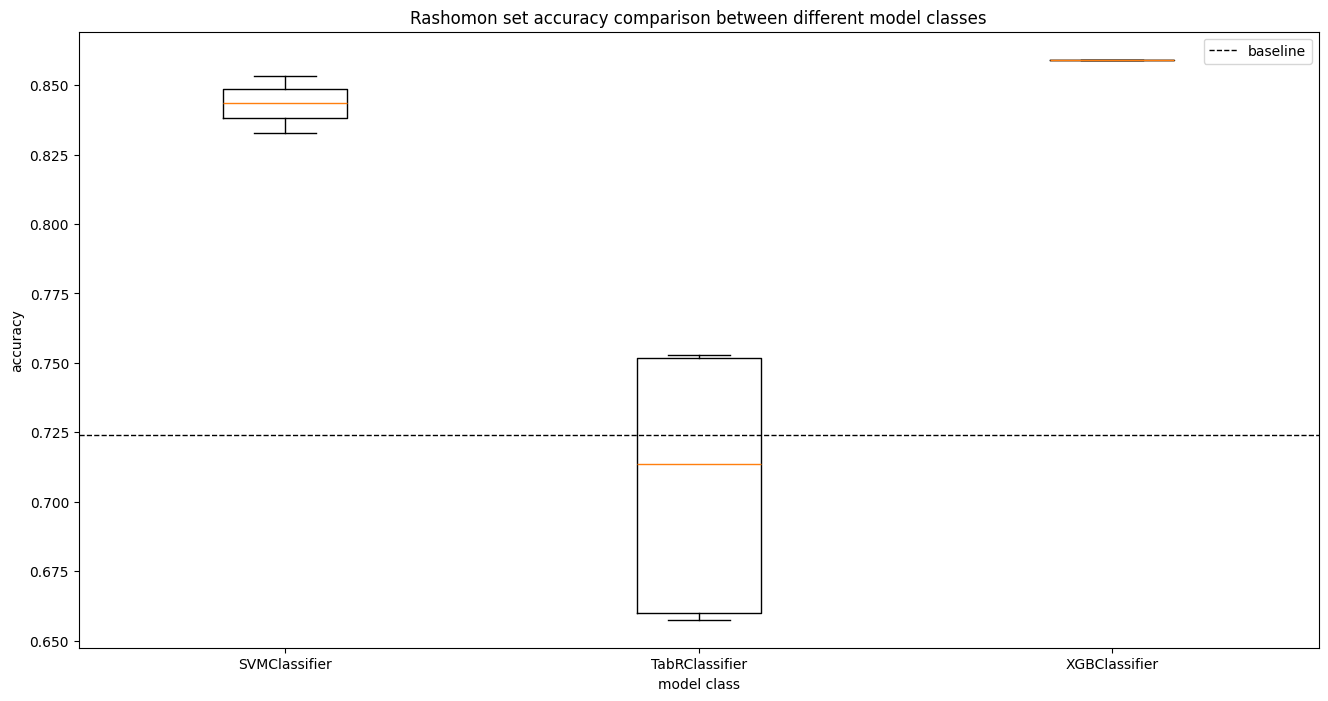

In [14]:
# Compare accuracies for different Rashomon sets
plt.figure(figsize=(16, 8))
plt.title("Rashomon set accuracy comparison between different model classes")
plt.axhline(BASELINE, color='black', linestyle='--', linewidth=1, label='baseline')
plt.xlabel('model class')
plt.ylabel('accuracy')
plt.boxplot([accuracies[model_class.__name__] for model_class in MODELS])
plt.xticks(np.arange(1, 1+len(MODELS)), [model_class.__name__ for model_class in MODELS])
plt.legend()

In [15]:
INDICES = [42, 123, 314]
RANDOM_SAMPLES = [X_test.iloc[i, :] for i in INDICES]

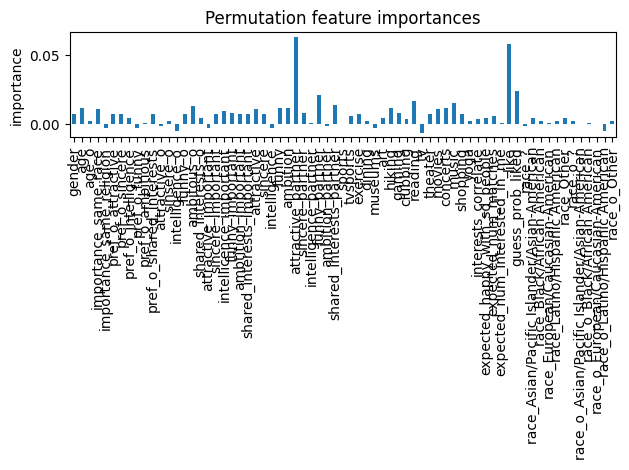

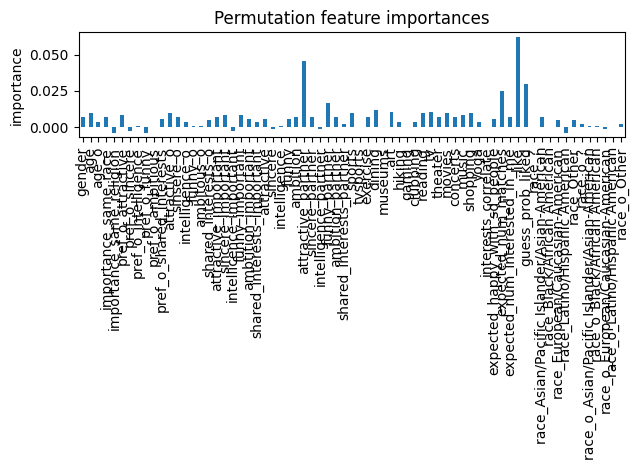

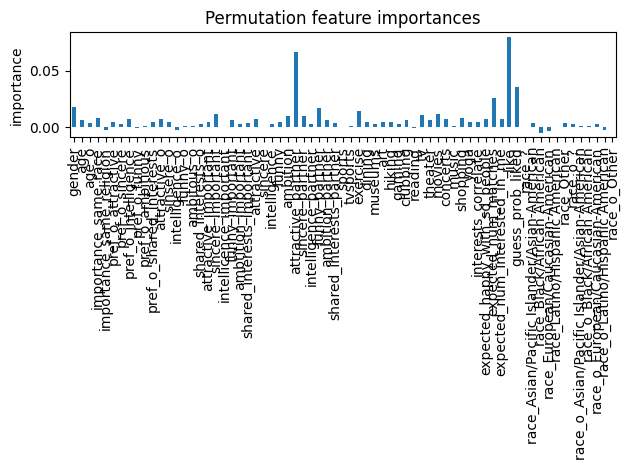

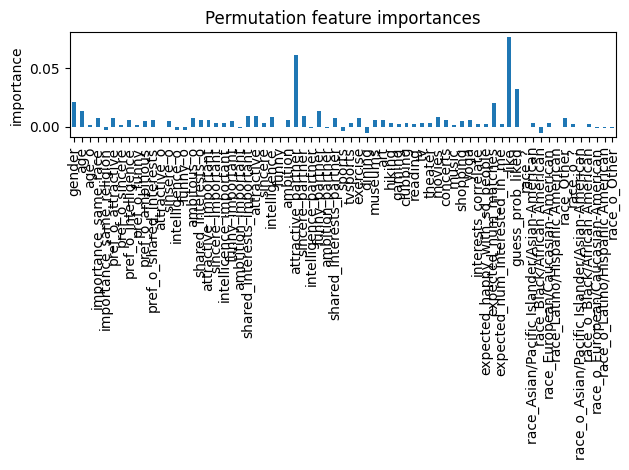

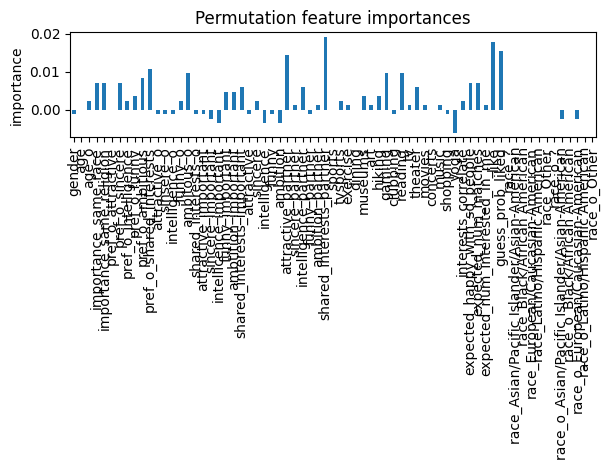

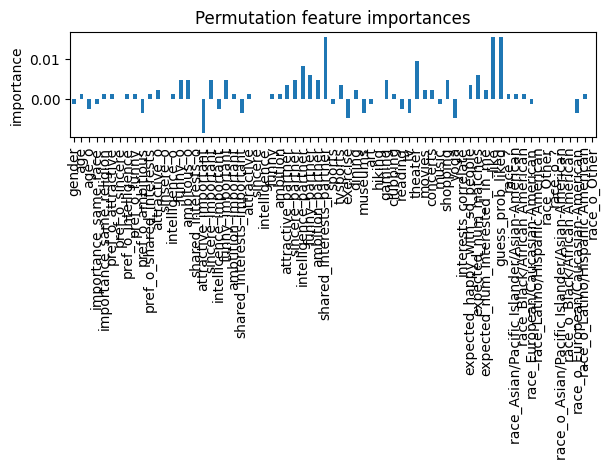

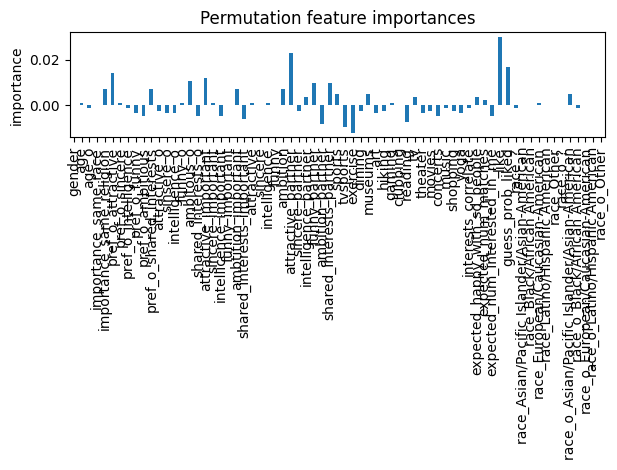

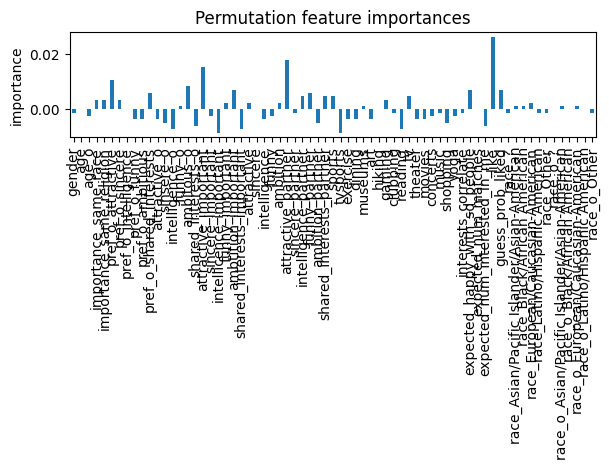

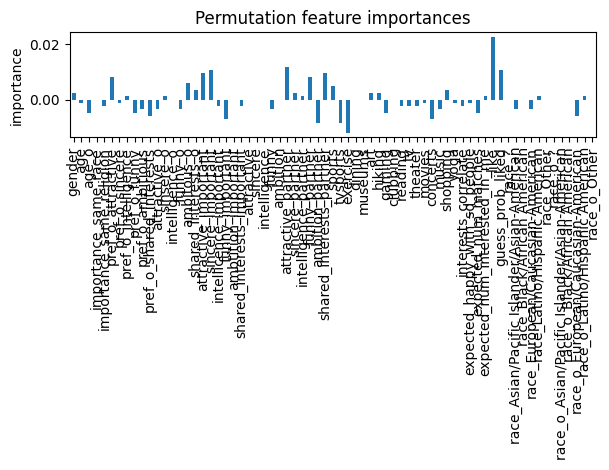

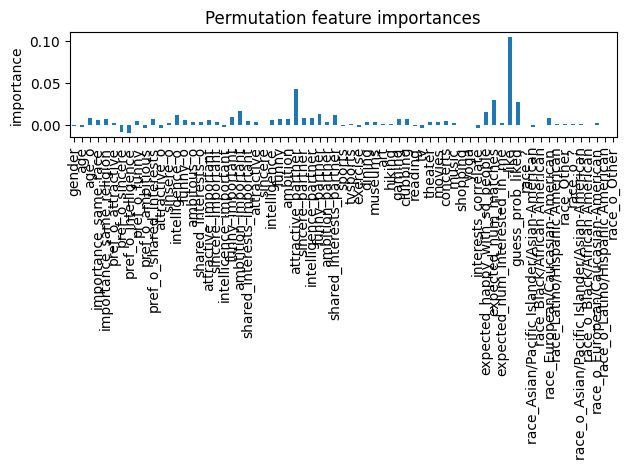

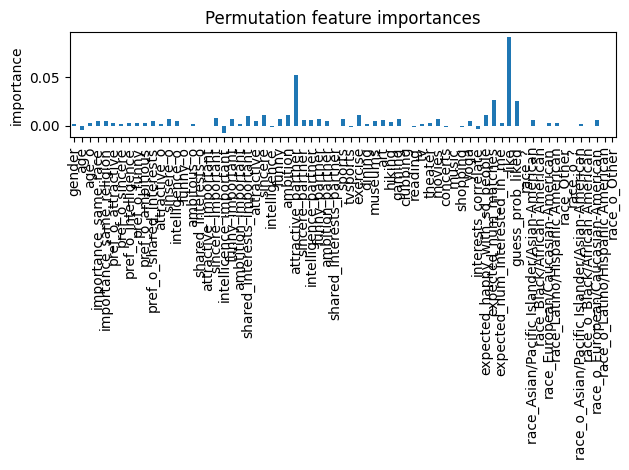

In [18]:
# Permutation feature importance

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for model_class in MODELS:
        for model in rashomon_sets[model_class.__name__]:
            importances = permutation_importance(model, X_test, y_test,
                           n_repeats=1,
                           random_state=SEED,
                            scoring="accuracy")
            importances = pd.Series(importances['importances'][:, 0], index=list(X.columns))
            fig, ax = plt.subplots()
            importances.plot.bar(ax=ax)
            ax.set_title("Permutation feature importances")
            ax.set_ylabel("importance")
            fig.tight_layout()

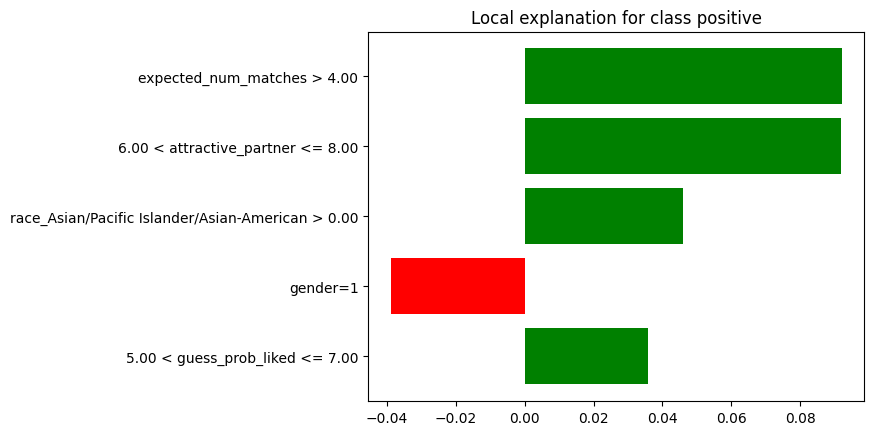

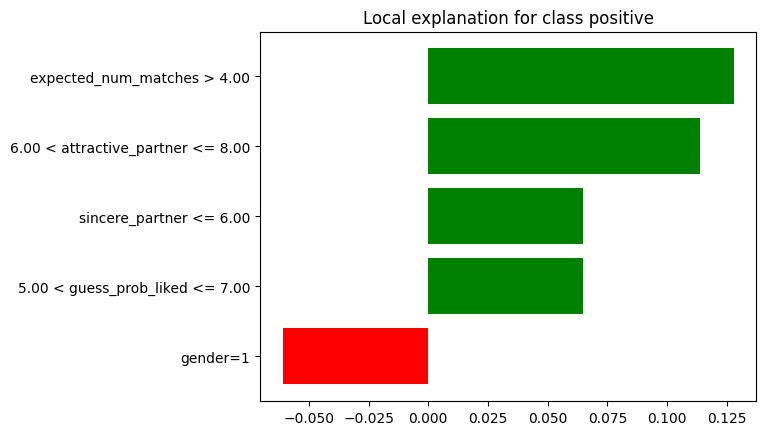

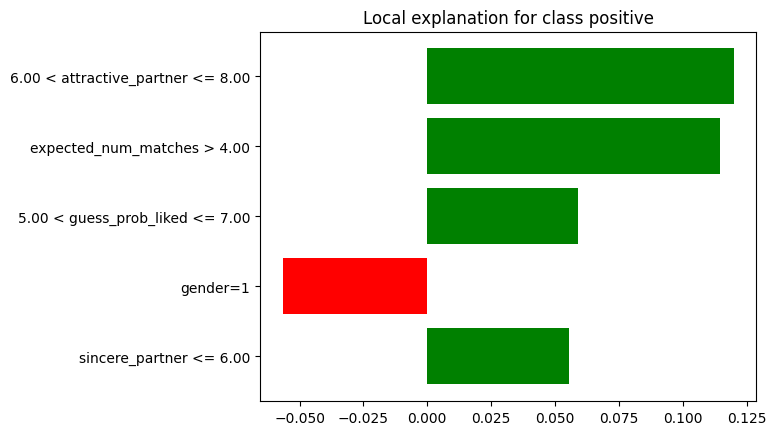

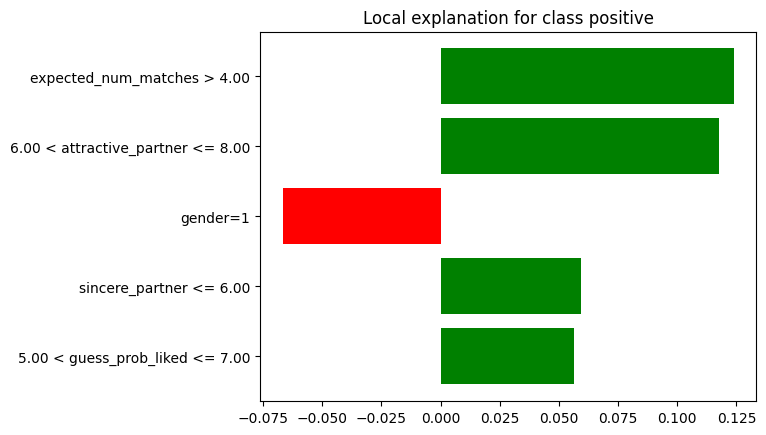

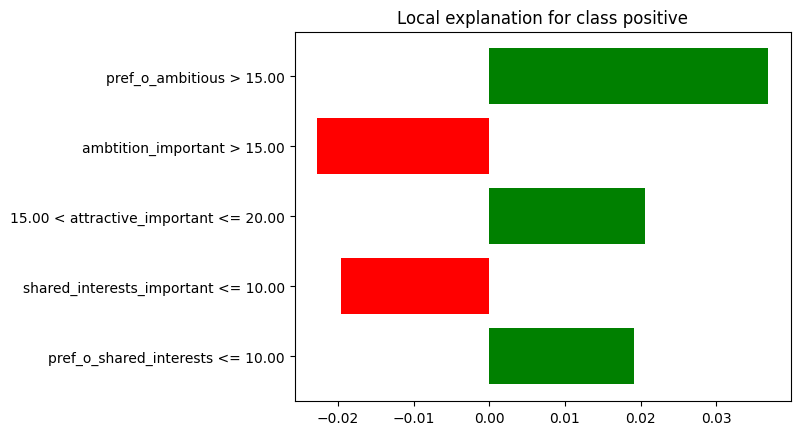

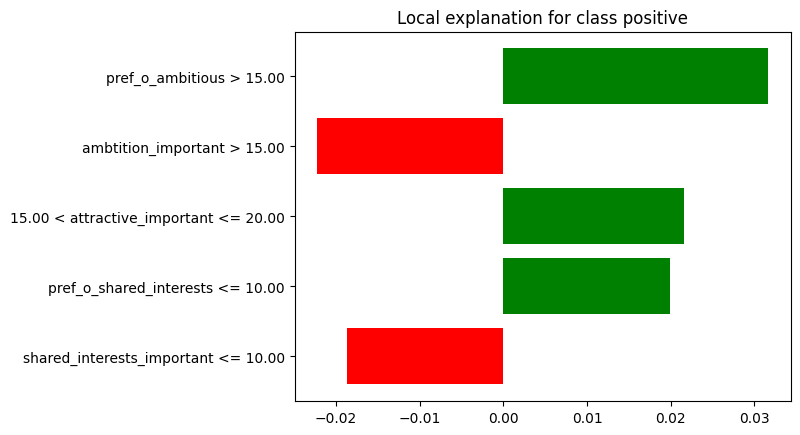

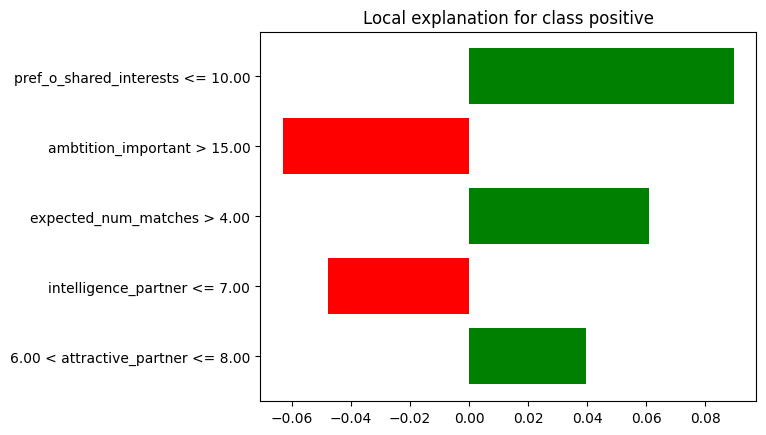

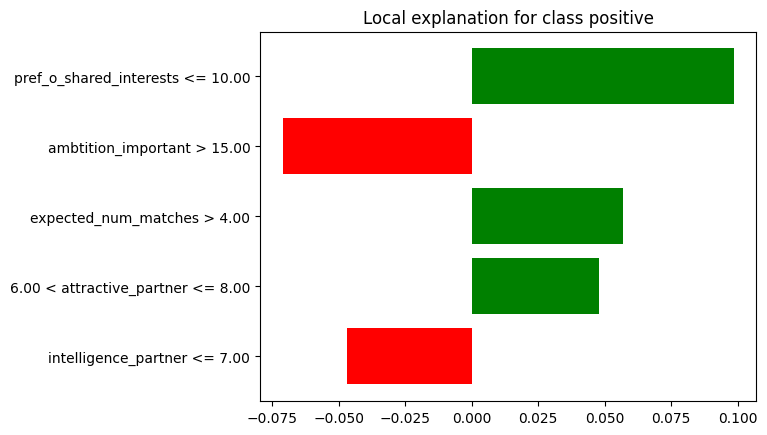

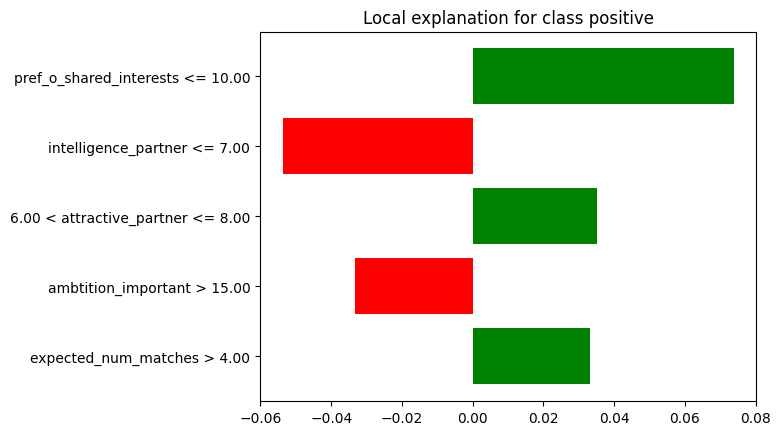

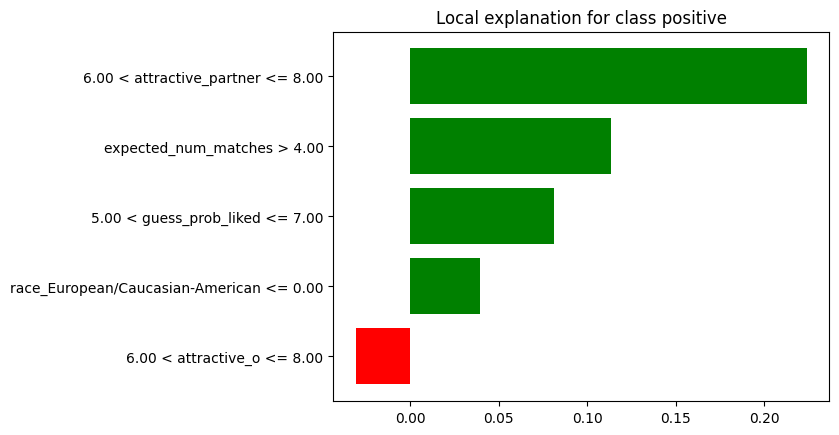

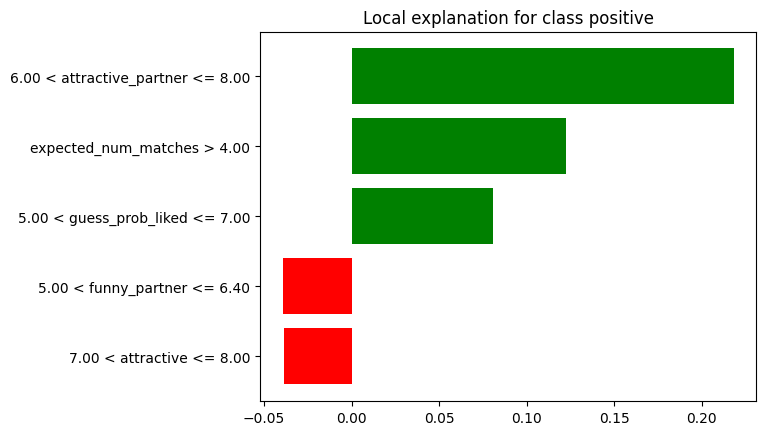

In [24]:
# LIME
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    categorical_features = [0, 3, 4, -1]
    lime_explainer = lime.lime_tabular.LimeTabularExplainer(X.to_numpy(), categorical_features=categorical_features, feature_names=list(X.columns), class_names=['negative', 'positive'])
    for model_class in MODELS:
        for model in rashomon_sets[model_class.__name__]:
            explaination = lime_explainer.explain_instance(X_test.iloc[SEED, :], model.predict_proba, num_features=5)
            fig = explaination.as_pyplot_figure()
            plt.plot()


In [22]:
# Shap
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for model_class in MODELS:
        for model in rashomon_sets[model_class.__name__]:
            shap_explainer = shap.KernelExplainer(model.predict, X_train, feature_names=list(X.columns))
            explaination = shap_explainer(X_test.iloc[[SEED], :])
            shap_values = explaination.values
            shap.plots.beeswarm(explaination)
            plt.plot()


AttributeError: can't set attribute 'feature_names_in_'